# [Inference] Semantic Segmentation with 🤗 Transformers

This notebook tests the pretrained model with a custom dataset.

## Inference

Now comes the exciting part -- using our fine-tuned model! In this section, we'll show how you can load your model from the hub and use it for inference. 

However, you can also try out your model directly on the Hugging Face Hub, thanks to the cool widgets powered by the [hosted inference API](https://api-inference.huggingface.co/docs/python/html/index.html). If you pushed your model to the Hub in the previous step, you should see an inference widget on your model page. You can add default examples to the widget by defining example image URLs in your model card. See [this model card](https://huggingface.co/segments-tobias/segformer-b0-finetuned-segments-sidewalk/blob/main/README.md) as an example.

<figure class="image table text-center m-0 w-full">
    <video 
        alt="The interactive widget of the model"
        style="max-width: 70%; margin: auto;"
        autoplay loop autobuffer muted playsinline
    >
      <source src="assets/56_fine_tune_segformer/widget.mp4" poster="assets/56_fine_tune_segformer/widget-poster.png" type="video/mp4">
  </video>
</figure>

### Use the model from the Hub

We'll first load the model from the Hub using `SegformerForSemanticSegmentation.from_pretrained()`.

In [1]:
model_checkpoint = "nvidia/mit-b0"  # pre-trained model from which to fine-tune

In [2]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

feature_extractor = SegformerFeatureExtractor.from_pretrained(model_checkpoint)
hf_username = "eborghi10"
hub_model_id = "segformer-vineyard-rows"
model = SegformerForSemanticSegmentation.from_pretrained(f"{hf_username}/{hub_model_id}")

/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Next, we'll load an image from our test dataset and its associated ground truth segmentation label.

In [3]:
from datasets import load_dataset
import os
hf_dataset_identifier = f"{hf_username}/VineyardRows"
ds = load_dataset(hf_dataset_identifier, token=os.getenv("HF_TOKEN"))

In [4]:
# ds = ds.shuffle(seed=1)
# ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["validation"]#["test"]
len(train_ds), len(test_ds)

(452, 48)

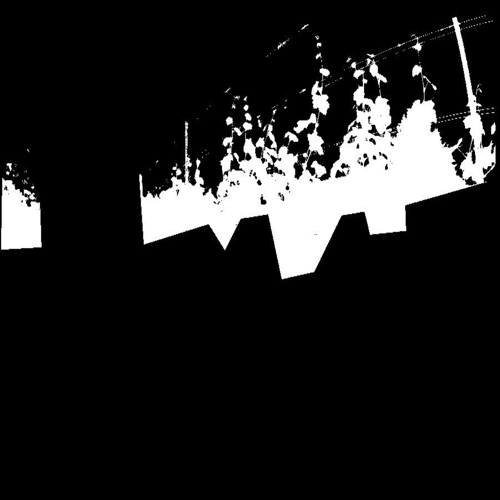

In [8]:
image = test_ds[0]['pixel_values']
gt_seg = test_ds[0]['label'].resize((500,500))
gt_seg

To segment this test image, we first need to prepare the image using the feature extractor. Then we'll forward it through the model.

We also need to remember to upscale the output logits to the original image size. In order to get the actual category predictions, we just have to apply an `argmax` on the logits.

In [9]:
from torch import nn
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor(reduce_labels=True)

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

/usr/local/lib/python3.12/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


Now it's time to display the result. The next cell defines the colors for each category, so that they match the "category coloring" on Segments.ai.

In [13]:
#@title `def seg_palette()`

def seg_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
    ]

The next function overlays the output segmentation map on the original image.

In [21]:
import numpy as np

def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(seg_palette())
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Make sure the image has the same size as the segmentation
  image = image.resize((seg.shape[1], seg.shape[0]))

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

We'll display the result next to the ground-truth mask.

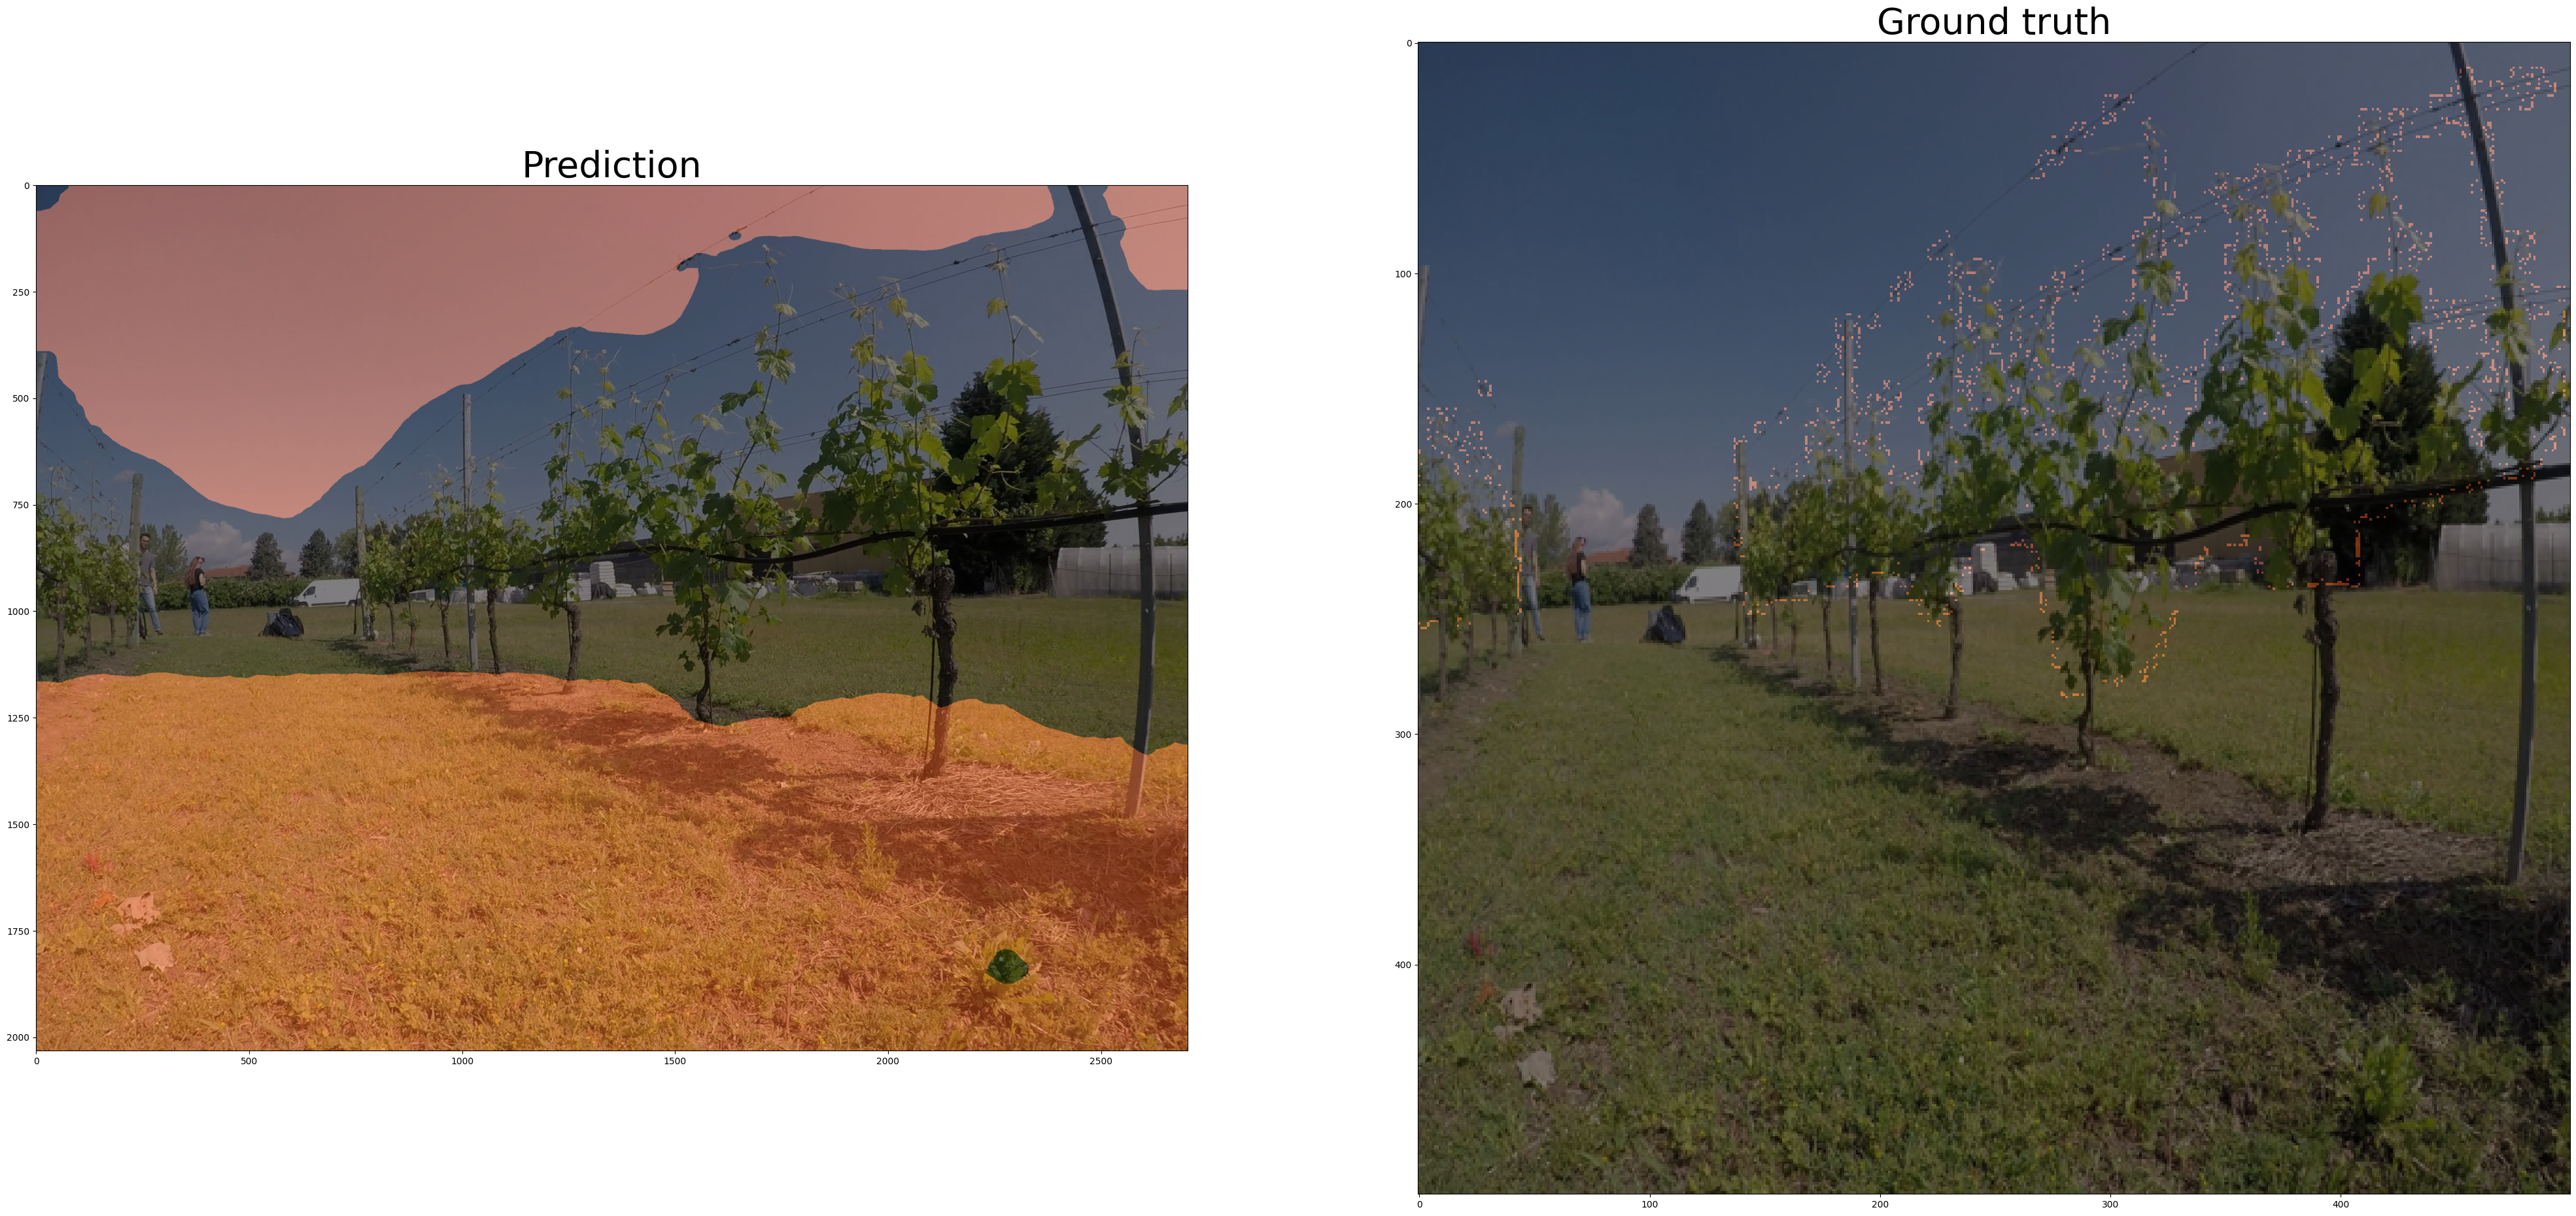

In [22]:
import matplotlib.pyplot as plt

pred_img = get_seg_overlay(image, pred_seg)
gt_img = get_seg_overlay(image, np.array(gt_seg))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {'fontsize': 40})
axs[0].imshow(pred_img)
axs[1].set_title("Ground truth", {'fontsize': 40})
axs[1].imshow(gt_img)

What do you think? Would you send our pizza delivery robot on the road with this segmentation information?

The result might not be perfect yet, but we can always expand our dataset to make the model more robust. We can now also go train a larger SegFormer model, and see how it stacks up. If you want to explore further beyond this notebook, here are some things you can try next:

* Train the model for longer. 
* Try out the different segmentation-specific training augmentations from libraries like [`albumentations`](https://albumentations.ai/docs/getting_started/mask_augmentation/). 
* Try out a larger variant of the SegFormer model family or try an entirely new model family like MobileViT. 